# Variable Importance

This notebook documents calculations of variable importance via decrease in Sharpe Ratio and $R^2$ when a variable is omitted from the model.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys 
import datetime as dt
import statsmodels.api as sm

import sys
sys.path.append('..')

from src.features.build_features import make_rff
from src.utils.utils import unpack_results

## Calculate performances of models with one variable omitted

In [2]:
data = pd.read_csv("../data/processed/processed_data.csv", index_col=0, parse_dates=True)

In [3]:
from_seed = 1
to_seed = 1000
interim_data_path = "../data/interim/variable_importance"
preprocessed_data_path = "../data/processed/processed_data.csv"
save_path = "../reports/figures/variable_importance"

with open(interim_data_path + "/config.json", 'r') as fp:
    config = json.load(fp)
    last_run_seed = config['last_run_seed']
    gamma = config['gamma']
    T_list = config['T_list']
    z_list = config['z_list']
    P_dict = config['P_dict']
    P_max = 12000
    delta_t = config['delta_t']
    vars_to_exclude = config['vars_to_exclude']

run_params_unpacking = (T_list, P_dict, z_list) 

data = pd.read_csv(preprocessed_data_path, index_col=0, parse_dates=True)
dates = data.index[min(T_list):]

interim_data = pd.read_csv('../data/interim/formatted_goyal_data.csv', index_col=0, parse_dates=True)
interim_data = interim_data.loc[interim_data.index > dt.datetime(1927, 1, 1)]

realized_R = interim_data.R
sigma_R = (realized_R**2).rolling(12).mean().apply(np.sqrt) 

In [4]:
# final results
output_df = pd.DataFrame(columns=['r2', 'sr'], index=vars_to_exclude)
output_df

,r2,sr
dfy,NaN,NaN
infl,NaN,NaN
svar,NaN,NaN
de,NaN,NaN
lty,NaN,NaN
tms,NaN,NaN
tbl,NaN,NaN
dfr,NaN,NaN
dp,NaN,NaN
dy,NaN,NaN


In [5]:
r = np.load(f"{interim_data_path}/return_forecasts/0001_var01_return_forecasts.npy")
r[:,0,0,0]

array([        nan,  0.00424989,  0.01050628, ..., -0.01283283,
       -0.03619671, -0.03227595])

In [6]:
r = r[1:,0,0,0]

In [7]:
len(r)

1104

In [8]:
realized_R = realized_R.values[-len(r):]
sigma_R = sigma_R.values[-len(r):]

In [9]:
for var_id, var in enumerate(vars_to_exclude):
    print(f"var: {var}")

    first_pass = True
    sr=0
    r2=0
    for seed in range(from_seed, to_seed+1):
        # print every 100th seed
        if seed % 100 == 0:
            print(f"seed: {seed}")
        r = np.load(f"{interim_data_path}/return_forecasts/{seed:04}_var{var_id:02}_return_forecasts.npy")
        r = r[1:,0,0,0]

        strategy_returns = r * realized_R
        return_forecasts_rescaled = r * sigma_R

        #### calculate metrics
        # R2
        forecast_errors = return_forecasts_rescaled - realized_R
        r2 += (1 - forecast_errors.var() / realized_R.var())
        
        # sharpe ratio
        sr += strategy_returns.mean() / strategy_returns.std()

    output_df.loc[var, 'r2'] = r2 / (to_seed - from_seed + 1)
    output_df.loc[var, 'sr'] = np.sqrt(12) * sr / (to_seed - from_seed + 1)

var: dfy
seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000
var: infl
seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000
var: svar
seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000
var: de
seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000
var: lty
seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000
var: tms
seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000
var: tbl
seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000
var: dfr
seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000
var: dp
seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000
var: dy
se

In [10]:
realized_R.var()

0.0029063247610782903

In [11]:
output_df

,r2,sr
dfy,0.000211,0.424936
infl,-0.000324,0.488764
svar,-0.000306,0.424308
de,-0.000147,0.418767
lty,0.00035,0.43351
tms,-0.000315,0.433109
tbl,0.0001,0.422003
dfr,-0.004398,0.408506
dp,-0.000771,0.401921
dy,-0.000514,0.405956


## Calculate performance of the full model

In [12]:
# full model results:
from_seed = 1
to_seed = 1000
interim_data_path = "../data/interim/simulation_outputs_voc_solver"
preprocessed_data_path = "../data/processed/processed_data.csv"
# save_path = "../reports/figures/curves_voc_solver"

with open(interim_data_path + "/config.json", 'r') as fp:
    config = json.load(fp)
    last_run_seed = config['last_run_seed']
    gamma = config['gamma']
    T_list = config['T_list']
    z_list = config['z_list']
    P_dict = config['P_dict']
    P_max = 12000
    delta_t = config['delta_t']

data = pd.read_csv(preprocessed_data_path, index_col=0, parse_dates=True)
dates = data.index[min(T_list):]

interim_data = pd.read_csv('../data/interim/formatted_goyal_data.csv', index_col=0, parse_dates=True)
interim_data = interim_data.loc[interim_data.index > dt.datetime(1927, 1, 1)]

# reminder: interim_data.R is UNSCALED EXCESS returns of S&P500 wrt Rfree
realized_R = interim_data.R
sigma_R = (realized_R**2).rolling(12).mean().apply(np.sqrt) 

run_params_unpacking = (T_list, P_dict, z_list) 

first_pass = True

for seed in range(from_seed, to_seed+1):
    if seed % 100 == 0:
        print(f"seed: {seed}")
    # load results
    b = np.load(f"{interim_data_path}/beta_norm_sq/{seed:04}beta_norm_sq.npy")
    r = np.load(f"{interim_data_path}/return_forecasts/{seed:04}return_forecasts.npy")

    # unpack results
    beta_norm_sq_df, return_forecasts_df = unpack_results((b, r), run_params_unpacking, dates)


    # here: position = scaled forecast of excess return 
    # alternative: position = forecasted return / beta 
    strategy_returns_rescaled = return_forecasts_df.multiply(realized_R, axis=0)

    # rescale forecasted returns because they were scaled by vola
    return_forecasts_rescaled = return_forecasts_df.multiply(sigma_R, axis=0)

    #### calculate metrics

    # R2
    forecast_errors = return_forecasts_rescaled.subtract(realized_R, axis=0)
    R_sq = 1 - forecast_errors.var() / realized_R.var()
    R_sq_temp = (R_sq
                .to_frame()
                .unstack()
                .droplevel(0, axis=1)
                .reset_index()
                )
    R_sq_temp['c'] = R_sq_temp['P']/R_sq_temp['T']
    R_sq_temp.head()

    # expected returns
    strategy_returns = strategy_returns_rescaled.mean().unstack().reset_index()
    strategy_returns['c'] = strategy_returns['P']/strategy_returns['T']
    strategy_returns.head()

    # volatility
    strategy_vola = strategy_returns_rescaled.std().unstack().reset_index()
    strategy_vola['c'] = strategy_vola['P']/strategy_vola['T']

    # sharpe ratio
    # TODO rescale to annualized sharpe ratio (annualizes expected returns over annualized volatility)
    sharpe_ratio = strategy_returns.copy()
    sharpe_ratio.loc[:, z_list] = strategy_returns.loc[:, z_list] / strategy_vola.loc[:, z_list] * np.sqrt(12)


    # initialize the average dataframes
    # otherwise average metrics over seeds
    if first_pass:
        R_sq_avg = R_sq_temp
        sharpe_ratio_avg = sharpe_ratio

        first_pass = False
    else:
        # average dataframes over different seeds
        # fill_value=0 makes addition use 0 for missing values. I did not see any NaNs in the dataframes
        R_sq_avg.loc[:,z_list] = R_sq_avg.loc[:,z_list].add(R_sq_temp.loc[:,z_list], fill_value=0)
        sharpe_ratio_avg.loc[:,z_list] = sharpe_ratio_avg.loc[:,z_list].add(sharpe_ratio.loc[:,z_list], fill_value=0)

R_sq_avg.loc[:,z_list] = R_sq_avg.loc[:,z_list] / (to_seed )
sharpe_ratio_avg.loc[:,z_list] = sharpe_ratio_avg.loc[:,z_list] / (to_seed )


seed: 100
seed: 200
seed: 300
seed: 400
seed: 500
seed: 600
seed: 700
seed: 800
seed: 900
seed: 1000


## Calculating VI as a difference in performances

In [13]:
# take sr and r2 for the full model for T=12, P=12000, z=1000
full_model_r2 = R_sq_avg.loc[(R_sq_avg['T']==12) & (R_sq_avg['P']==12000), 1000].values[0]
full_model_sr = sharpe_ratio_avg.loc[(R_sq_avg['T']==12) & (R_sq_avg['P']==12000), 1000].values[0]

full_model_r2

0.019077041772436895

In [14]:
vi = output_df.copy()
vi

,r2,sr
dfy,0.000211,0.424936
infl,-0.000324,0.488764
svar,-0.000306,0.424308
de,-0.000147,0.418767
lty,0.00035,0.43351
tms,-0.000315,0.433109
tbl,0.0001,0.422003
dfr,-0.004398,0.408506
dp,-0.000771,0.401921
dy,-0.000514,0.405956


In [15]:
full_model_r2

0.019077041772436895

In [16]:
vi['sr'] = (full_model_sr - vi['sr'])/full_model_sr
vi['r2'] = (full_model_r2 - vi['r2'])/full_model_r2 - 1
vi

,r2,sr
dfy,-0.011044,-0.010907
infl,0.016961,-0.162751
svar,0.01606,-0.009412
de,0.007685,0.003769
lty,-0.018365,-0.031304
tms,0.016527,-0.030349
tbl,-0.00523,-0.003929
dfr,0.230555,0.028181
dp,0.040425,0.043847
dy,0.026942,0.034246


In [17]:
# sort vi by r2
vi = vi.sort_values('r2', ascending=False)

In [18]:
vi

,r2,sr
mr,0.536696,0.247847
ltr,0.504714,0.181502
dfr,0.230555,0.028181
ep,0.077787,0.054247
dp,0.040425,0.043847
dy,0.026942,0.034246
infl,0.016961,-0.162751
tms,0.016527,-0.030349
svar,0.01606,-0.009412
de,0.007685,0.003769


## Plot the results

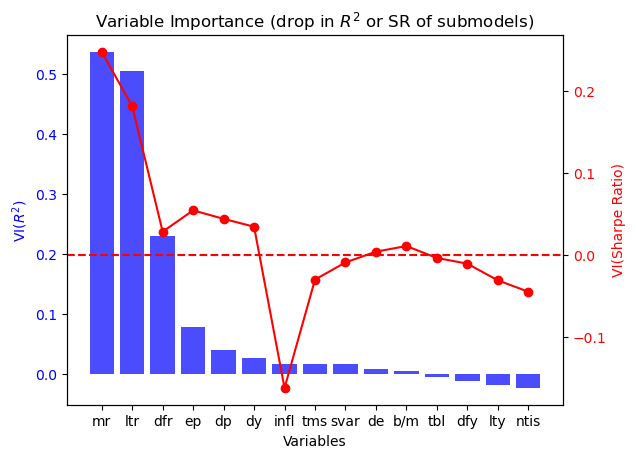

In [19]:
# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plot histogram for 'r2' on left y-axis
ax1.bar(vi.index, vi['r2'], color='blue', alpha=0.7)
ax1.set_xlabel('Variables')
#ax1.set_ylabel(r'$R^2$(full model) - $R^2$(submodel)', color='blue')
ax1.set_ylabel(r'VI$(R^2)$', color='blue')

ax1.tick_params(axis='y', labelcolor='blue')
# lower bound for y-axis
#ax1.set_ylim(vi["r2"].min()*0.95, vi["r2"].max()*1.05)

# Create another y-axis for 'sr' values
ax2 = ax1.twinx()
ax2.plot(vi.index, vi['sr'], color='red', marker='o')
ax2.set_ylabel('VI(Sharpe Ratio)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# add a horizontal line at y=0 for sr
ax2.axhline(y=0, color='red', linestyle='--')

plt.title('Variable Importance (drop in $R^2$ or SR of submodels)')

# Show the plot
#plt.title('Histogram of R2 values and Line plot of SR values')
plt.show()

In [20]:
# save the plot
fig.savefig(f"{save_path}/variable_importance.png", dpi=300)

# Concluding Notes

In preprocessing we lagged inflation one period more than the authors of the original paper did. This made `infl` variable less informative and hence less important, so much so that its variable importance measured by decrease in Sharpe Ratio is negative. This means that if we were to maximize SR, we would have to omit `infl` from the model. In the original paper, VI(SR) for `infl` was around -0.02, here we have less then -0.1, probably around -0.15. 

In conclusion, although the increase in complexity, in the case of ridgless regression on RFFs, leads to an improvement in performance, notably Sharpe Ratio, the complexity must not be increased by addition of uninformative variables. The double descent happens only because additional nodes in the middle layer (parameter P) actually introduces additional regulation of the model. Adding junk predictors is not an additional regulation and it leads nowhere. Some kind of variable selection is still necessary. 

Importance of `mr` indicates the trend following behavior of the model. `ltr` (Long-Term Bond Rate of Returns) are importante but long term yields and the term spread are not. `dfr` is the difference between long-term corporate bond and long-term government bond returns. Again, yields are not important, but the returns on the bonds are. Seems like the model is capturing momentum in the bond market as well. `ep`, `dp` and `dy` (dividend/lagged prices) are important, but `de` is not. The first three variables are ratio of something to price (or lagged price), while `de` is not. Overall, seems like this model is mainly exploiting the momentum.